<a href="https://colab.research.google.com/github/Marta-Michalik/Critical-Node-Detection/blob/main/Critical_Node_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Critical Node Detection in Telecommunication Networks**

In [ ]:
!pip install docplex cplex
from docplex.mp.model import Model
from docplex.util.status import JobSolveStatus

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pprint


     |████████████████████████████████| 634 kB 8.7 MB/s 
     |████████████████████████████████| 30.9 MB 232 kB/s 
  Created wheel for docplex: filename=docplex-2.22.213-py3-none-any.whl size=696882 sha256=0173a4684ad32121555f120f27346a405e495046566cb157eb235f58b9d33f22
  Stored in directory: /root/.cache/pip/wheels/90/69/6b/1375c68a5b7ff94c40263b151c86f58bd72200bf0c465b5ba3
Successfully built docplex


In [ ]:
import itertools
import random

### Model matematyczny

$$\min \sum_{i=1}^{n-1}\sum_{j=i+1}^{n}w_{ij}u_{ij} $$

1. $$u_{ij} + v_{i} + v_{j} > 1 \quad  (i,j)\in E $$

3. $$ \sum\limits^{n}_{i=1} v_{i} \leq p $$

3. $$+u_{ij}+u_{jk}-u_{ik} \leq 1 \quad (i,j,k)\in T $$

4. $$+u_{ij}-u_{jk}+u_{ik} \leq 1 \quad (i,j,k)\in T $$

5. $$-u_{ij}+u_{jk}+u_{ik} \leq 1 \quad (i,j,k)\in T $$

6. $$u_{ij} \in \{0,1\} \quad \quad i=1,...,(n-1),\ j=(i+1),...,n$$

7. $$u_{i} \in \{0,1\} \quad  i=1,...,n$$
 

In [ ]:
def print_graph(graph, cost_key='cost', print_cost=True, path_edgelist=None, what_edgelist=None):

  if not path_edgelist:
    print(f'{graph}.\nNodes: {graph.nodes}.\nEdges: {graph.edges}.')

  for e_s, e_d, e_w in graph.edges(data=cost_key):
    if not e_w:
      e_w = graph.edges[e_s, e_d][cost_key] = 1
  # for e_s, e_d, e_data in graph.edges(data=True):
  #   e_data.setdefault(cost_key, 1)

  layout_seed = 1
  layout = nx.drawing.spring_layout(
    graph, 
    seed=layout_seed
  )
  
  nx.draw(
      graph, pos=layout, 
      node_color='aqua',
      node_size=500,
      with_labels=True
  )

  edge_labels = {(u,v): '\n'.join(map(lambda x: f'{x[0]}={x[1]}', d.items())) for u,v,d in graph.edges(data=True)}
  if print_cost: nx.draw_networkx_edge_labels(graph, layout, edge_labels=edge_labels)

  width_map = [d['cost'] for u,v,d in graph.edges(data=True)]

  if path_edgelist:
    nx.draw_networkx_edges(graph, layout, edgelist=graph.edges, edge_color='grey', width=width_map)
    nx.draw_networkx_edges(graph, layout, edgelist=path_edgelist, edge_color='red', width=2)
  else: 
    nx.draw_networkx_edges(graph, layout, edgelist=graph.edges, edge_color='black', width=width_map)

  plt.title(what_edgelist or 'Network graph')
  
  plt.show()

Graph:
DiGraph with 7 nodes and 26 edges.
Nodes: ['Gdansk', 'Olsztyn', 'Poznan', 'Warszawa', 'Krakow', 'Rzeszow', 'Wroclaw'].
Edges: [('Gdansk', 'Olsztyn'), ('Gdansk', 'Poznan'), ('Gdansk', 'Warszawa'), ('Olsztyn', 'Gdansk'), ('Olsztyn', 'Rzeszow'), ('Olsztyn', 'Warszawa'), ('Poznan', 'Gdansk'), ('Poznan', 'Krakow'), ('Poznan', 'Warszawa'), ('Poznan', 'Wroclaw'), ('Warszawa', 'Gdansk'), ('Warszawa', 'Krakow'), ('Warszawa', 'Olsztyn'), ('Warszawa', 'Poznan'), ('Warszawa', 'Rzeszow'), ('Warszawa', 'Wroclaw'), ('Krakow', 'Poznan'), ('Krakow', 'Rzeszow'), ('Krakow', 'Warszawa'), ('Krakow', 'Wroclaw'), ('Rzeszow', 'Krakow'), ('Rzeszow', 'Olsztyn'), ('Rzeszow', 'Warszawa'), ('Wroclaw', 'Krakow'), ('Wroclaw', 'Poznan'), ('Wroclaw', 'Warszawa')].


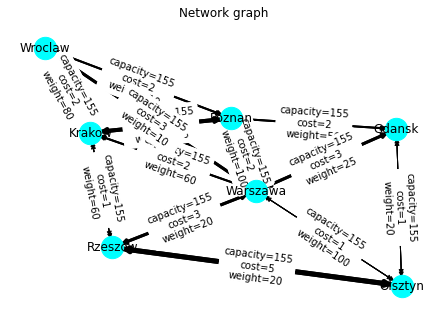

DiGraph with 34 nodes and 54 edges.
Nodes: ['Monachium', 'Augsburg', 'Ulm', 'Ratyzbona', 'Ingolstadt', 'Rosenheim', 'Norymberga', 'Stuttgart', 'Tybinga', 'Wurzburg', 'Lipsk', 'Drezno', 'Gorlitz', 'Berlin', 'Szczecin', 'Rostock', 'Hamburg', 'Magdeburg', 'Hanower', 'Brema', 'Naumunster', 'Kilonia', 'Flensburg', 'Brunszwik', 'Kassel', 'Frankfurt', 'Bielefeld', 'Munster', 'Dortmund', 'Essen', 'Dusseldorf', 'Kolonia', 'Bonn', 'Koblencja'].
Edges: [('Monachium', 'Augsburg'), ('Monachium', 'Ulm'), ('Monachium', 'Ratyzbona'), ('Monachium', 'Ingolstadt'), ('Monachium', 'Rosenheim'), ('Monachium', 'Norymberga'), ('Norymberga', 'Ingolstadt'), ('Norymberga', 'Ratyzbona'), ('Norymberga', 'Stuttgart'), ('Norymberga', 'Wurzburg'), ('Norymberga', 'Lipsk'), ('Stuttgart', 'Ulm'), ('Stuttgart', 'Tybinga'), ('Lipsk', 'Drezno'), ('Drezno', 'Gorlitz'), ('Drezno', 'Berlin'), ('Berlin', 'Lipsk'), ('Berlin', 'Szczecin'), ('Berlin', 'Rostock'), ('Berlin', 'Hamburg'), ('Berlin', 'Magdeburg'), ('Hamburg', 'Brema'

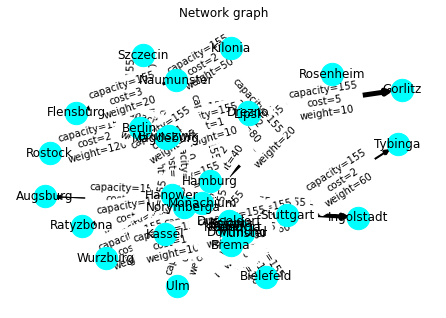

DiGraph with 5 nodes and 13 edges.
Nodes: ['Gdansk', 'Olsztyn', 'Warszawa', 'Krakow', 'Rzeszow'].
Edges: [('Gdansk', 'Olsztyn'), ('Gdansk', 'Warszawa'), ('Olsztyn', 'Gdansk'), ('Olsztyn', 'Rzeszow'), ('Olsztyn', 'Warszawa'), ('Warszawa', 'Gdansk'), ('Warszawa', 'Krakow'), ('Warszawa', 'Olsztyn'), ('Warszawa', 'Rzeszow'), ('Krakow', 'Rzeszow'), ('Krakow', 'Warszawa'), ('Rzeszow', 'Krakow'), ('Rzeszow', 'Olsztyn')].


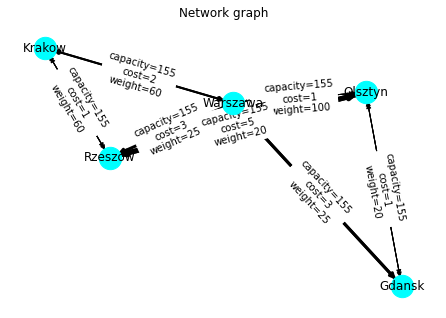

{'Gdansk', 'Olsztyn', 'Warszawa', 'Rzeszow', 'Krakow'}


In [ ]:
# Sieć polska
links = [('Gdansk', 'Olsztyn', {'capacity': 155, 'cost': 1 , 'weight': 10}),
 ('Olsztyn', 'Gdansk', {'capacity': 155, 'cost': 1, 'weight': 20}),
 ('Gdansk', 'Poznan', {'capacity': 155, 'cost': 2, 'weight': 100}),
 ('Poznan', 'Gdansk', {'capacity': 155, 'cost': 2, 'weight': 50}),
 ('Gdansk', 'Warszawa', {'capacity': 155, 'cost': 3, 'weight': 20}),
 ('Warszawa', 'Gdansk', {'capacity': 155, 'cost': 3, 'weight': 25}),
 ('Krakow', 'Poznan', {'capacity': 155, 'cost': 4, 'weight': 35}),
 ('Poznan', 'Krakow', {'capacity': 155, 'cost': 4, 'weight': 100}),
 ('Krakow', 'Rzeszow', {'capacity': 155, 'cost': 1, 'weight': 10}),
 ('Rzeszow', 'Krakow', {'capacity': 155, 'cost': 1, 'weight': 60}),
 ('Krakow', 'Warszawa', {'capacity': 155, 'cost': 2, 'weight': 60}),
 ('Warszawa', 'Krakow', {'capacity': 155, 'cost': 2, 'weight': 60}),
 ('Krakow', 'Wroclaw', {'capacity': 155, 'cost': 2, 'weight': 40}),
 ('Wroclaw', 'Krakow', {'capacity': 155, 'cost': 2, 'weight': 80}),
 ('Olsztyn', 'Rzeszow', {'capacity': 155, 'cost': 5, 'weight': 10}),
 ('Rzeszow', 'Olsztyn', {'capacity': 155, 'cost': 5, 'weight': 20}),
 ('Olsztyn', 'Warszawa', {'capacity': 155, 'cost': 1, 'weight': 20}),
 ('Warszawa', 'Olsztyn', {'capacity': 155, 'cost': 1, 'weight': 100}),
 ('Poznan', 'Warszawa', {'capacity': 155, 'cost': 2, 'weight': 120}),
 ('Warszawa', 'Poznan', {'capacity': 155, 'cost': 2, 'weight': 100}),
 ('Poznan', 'Wroclaw', {'capacity': 155, 'cost': 2, 'weight': 10}),
 ('Wroclaw', 'Poznan', {'capacity': 155, 'cost': 2, 'weight': 10}),
 ('Rzeszow', 'Warszawa', {'capacity': 155, 'cost': 3, 'weight': 20}),
 ('Warszawa', 'Rzeszow', {'capacity': 155, 'cost': 3, 'weight': 25}),
 ('Warszawa', 'Wroclaw', {'capacity': 155, 'cost': 3, 'weight': 30}),
 ('Wroclaw', 'Warszawa', {'capacity': 155, 'cost': 3, 'weight': 10})]

linkstest = [('Gdansk', 'Olsztyn', {'capacity': 155, 'cost': 1 , 'weight': 10}),
 ('Olsztyn', 'Gdansk', {'capacity': 155, 'cost': 1, 'weight': 20}),
 ('Gdansk', 'Warszawa', {'capacity': 155, 'cost': 3, 'weight': 20}),
 ('Warszawa', 'Gdansk', {'capacity': 155, 'cost': 3, 'weight': 25}),
 ('Krakow', 'Rzeszow', {'capacity': 155, 'cost': 1, 'weight': 10}),
 ('Rzeszow', 'Krakow', {'capacity': 155, 'cost': 1, 'weight': 60}),
 ('Krakow', 'Warszawa', {'capacity': 155, 'cost': 2, 'weight': 60}),
 ('Warszawa', 'Krakow', {'capacity': 155, 'cost': 2, 'weight': 60}),
 ('Olsztyn', 'Rzeszow', {'capacity': 155, 'cost': 5, 'weight': 10}),
 ('Rzeszow', 'Olsztyn', {'capacity': 155, 'cost': 5, 'weight': 20}),
 ('Olsztyn', 'Warszawa', {'capacity': 155, 'cost': 1, 'weight': 20}),
 ('Warszawa', 'Olsztyn', {'capacity': 155, 'cost': 1, 'weight': 100}),
 ('Warszawa', 'Rzeszow', {'capacity': 155, 'cost': 3, 'weight': 25})]


cities = set(link[0] for link in linkstest)

linksGermany = [('Monachium', 'Augsburg', {'capacity': 155, 'cost': 1 , 'weight': 10}),
 ('Monachium', 'Ulm', {'capacity': 155, 'cost': 1, 'weight': 20}),
 ('Monachium', 'Ratyzbona', {'capacity': 155, 'cost': 2, 'weight': 100}),
 ('Monachium', 'Ingolstadt', {'capacity': 155, 'cost': 2, 'weight': 50}),
 ('Monachium', 'Rosenheim', {'capacity': 155, 'cost': 3, 'weight': 20}),
 ('Monachium', 'Norymberga', {'capacity': 155, 'cost': 3, 'weight': 25}),
 ('Norymberga', 'Ingolstadt', {'capacity': 155, 'cost': 4, 'weight': 35}),
 ('Norymberga', 'Ratyzbona', {'capacity': 155, 'cost': 4, 'weight': 100}),
 ('Norymberga', 'Stuttgart', {'capacity': 155, 'cost': 1, 'weight': 10}),
 ('Stuttgart', 'Ulm', {'capacity': 155, 'cost': 1, 'weight': 60}),
 ('Stuttgart', 'Tybinga', {'capacity': 155, 'cost': 2, 'weight': 60}),
 ('Norymberga', 'Wurzburg', {'capacity': 155, 'cost': 2, 'weight': 60}),
 ('Norymberga', 'Lipsk', {'capacity': 155, 'cost': 2, 'weight': 40}),
 ('Lipsk', 'Drezno', {'capacity': 155, 'cost': 2, 'weight': 80}),
 ('Drezno', 'Gorlitz', {'capacity': 155, 'cost': 5, 'weight': 10}),
 ('Drezno', 'Berlin', {'capacity': 155, 'cost': 5, 'weight': 20}),
 ('Berlin', 'Lipsk', {'capacity': 155, 'cost': 1, 'weight': 20}),
 ('Berlin', 'Szczecin', {'capacity': 155, 'cost': 1, 'weight': 100}),
 ('Berlin', 'Rostock', {'capacity': 155, 'cost': 2, 'weight': 120}),
 ('Berlin', 'Hamburg', {'capacity': 155, 'cost': 2, 'weight': 100}),
 ('Berlin', 'Magdeburg', {'capacity': 155, 'cost': 2, 'weight': 10}),
 ('Magdeburg', 'Hanower', {'capacity': 155, 'cost': 2, 'weight': 10}),
 ('Hanower', 'Hamburg', {'capacity': 155, 'cost': 3, 'weight': 20}),
 ('Hamburg', 'Brema', {'capacity': 155, 'cost': 3, 'weight': 25}),
 ('Brema', 'Hanower', {'capacity': 155, 'cost': 3, 'weight': 30}),
 ('Hamburg', 'Naumunster', {'capacity': 155, 'cost': 3, 'weight': 10}),
 ('Naumunster', 'Kilonia', {'capacity': 155, 'cost': 2, 'weight': 50}),
 ('Naumunster', 'Flensburg', {'capacity': 155, 'cost': 3, 'weight': 20}),
 ('Hanower', 'Brunszwik', {'capacity': 155, 'cost': 3, 'weight': 25}),
 ('Brunszwik', 'Magdeburg', {'capacity': 155, 'cost': 4, 'weight': 35}),
 ('Magdeburg', 'Berlin', {'capacity': 155, 'cost': 4, 'weight': 100}),
 ('Magdeburg', 'Lipsk', {'capacity': 155, 'cost': 1, 'weight': 10}),
 ('Hanower', 'Kassel', {'capacity': 155, 'cost': 1, 'weight': 60}),
 ('Kassel', 'Norymberga', {'capacity': 155, 'cost': 2, 'weight': 60}),
 ('Kassel', 'Wurzburg', {'capacity': 155, 'cost': 2, 'weight': 60}),
 ('Kassel', 'Frankfurt', {'capacity': 155, 'cost': 2, 'weight': 40}),
 ('Brema', 'Bielefeld', {'capacity': 155, 'cost': 2, 'weight': 80}),
 ('Brema', 'Munster', {'capacity': 155, 'cost': 5, 'weight': 10}),
 ('Munster', 'Dortmund', {'capacity': 155, 'cost': 5, 'weight': 20}),
 ('Dortmund', 'Bielefeld', {'capacity': 155, 'cost': 1, 'weight': 20}),
 ('Dortmund', 'Essen', {'capacity': 155, 'cost': 1, 'weight': 100}),
 ('Dortmund', 'Dusseldorf', {'capacity': 155, 'cost': 2, 'weight': 120}),
 ('Dortmund', 'Kolonia', {'capacity': 155, 'cost': 2, 'weight': 100}),
 ('Dortmund', 'Bonn', {'capacity': 155, 'cost': 2, 'weight': 10}),
 ('Essen', 'Dusseldorf', {'capacity': 155, 'cost': 2, 'weight': 10}),
 ('Essen', 'Kolonia', {'capacity': 155, 'cost': 1, 'weight': 20}),
 ('Essen', 'Bonn', {'capacity': 155, 'cost': 2, 'weight': 100}),
 ('Dusseldorf', 'Kolonia', {'capacity': 155, 'cost': 2, 'weight': 50}),
 ('Dusseldorf', 'Bonn', {'capacity': 155, 'cost': 3, 'weight': 20}),
 ('Kolonia', 'Bonn', {'capacity': 155, 'cost': 3, 'weight': 25}),
 ('Bonn', 'Koblencja', {'capacity': 155, 'cost': 4, 'weight': 35}),
 ('Koblencja', 'Frankfurt', {'capacity': 155, 'cost': 4, 'weight': 100}),
 ('Frankfurt', 'Wurzburg', {'capacity': 155, 'cost': 1, 'weight': 10}),
 ('Frankfurt', 'Stuttgart', {'capacity': 155, 'cost': 1, 'weight': 60})]



print('Graph:')
graph = nx.DiGraph(links)
graphGermany = nx.DiGraph(linksGermany)
graphtest = nx.DiGraph(linkstest)
print_graph(graph)
print_graph(graphGermany)
print_graph(graphtest)

print(cities)


In [ ]:
cities = list(cities)
cities[0]

'Gdansk'

In [ ]:
def critical_node_detection(p, graph, path_edgelist=None, limit=None):

#p = critical nodes quantity
  print(graph)
  model = Model(name='CriticalNodeDetection')

  i_range = range(1, (len(graph.edges)-1))  
  i_range2 = range(1, (len(graph.edges)-1))
  j_range = range(2, len(graph.edges))
  k_range = range(3, (len(graph.edges))-1)
 
  I = range(0, len(graph.edges))
  IJ = list(indeksy(len(graph.edges), 2))
  T =list(indeksy(len(graph.edges), 3))

  u = model.binary_var_dict((i,j) for (j, i) in IJ )
  v = model.binary_var_dict((i) for i in I)
  
  cities = set(link[0] for link in linkstest)
  cities = list(cities)

  edges = [(i,j) for (j, i) in IJ] # set of links 
 
 

  #model.add_constraint(u[1,2] + u[2,1] <= 1)  
  #model.add_constraint(((u[i,j] for i in i_range for j in j_range)  + (u[j,k] for j in j_range for k in k_range) + (u[i,k] for i in i_range for k in k_range)) <= 1 ) 
 

  model.add_constraints(-u[i,j] + u[j,k] + u[i,k] <= 1 for (k, j, i) in T)
  model.add_constraints( u[i,j] - u[j,k] + u[i,k] <= 1 for (k, j, i) in T)
  model.add_constraints( u[i,j] + u[j,k] - u[i,k] <= 1 for (k, j, i) in T)
  print(u[1,2])
  model.add_constraints((u[i,j] + v[i] + v[j]  >= 1) for (j, i) in IJ )
  model.minimize(model.sum(links[i][2]['weight']*u[i,j] for (j, i) in IJ))
  model.add_constraint(model.sum(v[i] for i in I) <= p)
  solution = model.solve(log_output=True)

  status = model.get_solve_status()

  print(model)
  print('################')
  print(status)
  print('################')
  print(solution)
  print('################')

  for i in I:
    print(v[i].solution_value)
    if v[i].solution_value >= 1:
      print(linkstest[i])


  return model, solution

In [ ]:
p =5

critical_node_detection(p, graphtest, path_edgelist=None)

DiGraph with 5 nodes and 13 edges
x3
Version identifier: 20.1.0.1 | 2021-12-07 | 9dfdf6686
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced MIP has 937 rows, 91 columns, and 2821 nonzeros.
Reduced MIP has 91 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.13 ticks)
Found incumbent of value 3235.000000 after 0.02 sec. (3.55 ticks)
Probing time = 0.00 sec. (0.14 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 937 rows, 91 columns, and 2821 nonzeros.
Reduced MIP has 91 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.72 ticks)
Probing time = 0.00 sec. (0.14 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 2 threads.
Root relaxation solution time = 0.08 sec. (2.40 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound 

(docplex.mp.Model['CriticalNodeDetection'],
 docplex.mp.solution.SolveSolution(obj=575,values={x1:1,x7:1,x8:1,x11:1,x..)

In [ ]:
def indeksy(N, length=1):

    if length == 1:
       for x in range(N):
           yield (x,)
    else:
       for x in range(1, N):
            for t in indeksy(x, length - 1):
                yield (x,) + t

In [ ]:
linkstest[0]

('Gdansk', 'Olsztyn', {'capacity': 155, 'cost': 1, 'weight': 10})

In [ ]:
links[1][2]['weight']

20